In [1]:
# Cell 1: Imports
# Basic OS, date/time, and numerical libraries
import os
from datetime import datetime
import numpy as np

# Libraries for data handling and scientific computing
import xarray as xr
import dask.array as da # For handling large arrays that don't fit in memory

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F # For functions like F.pad, F.gelu
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning for streamlining training
import lightning.pytorch as pl

# Plotting library
import matplotlib.pyplot as plt

# Pandas for data manipulation (e.g., creating submission CSV)
import pandas as pd


In [2]:
# Cell 2: Configuration
# Main configuration dictionary for the experiment

# NOTE: You MUST change the 'path' in config['data'] to the correct location 
# of your 'processed_data_cse151b_v2_corrupted_ssp245.zarr' file.
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245", 
        "test_months": 120,  
        "batch_size": 64,    
        "num_workers": 4,    
    },
    "model_fno": { # Configuration specific to FNO
        "type": "fno",
        "modes1": 16,             # Number of Fourier modes in height dimension (max H/2, e.g., 48/2=24)
        "modes2": 16,             # Number of Fourier modes in width dimension (max W/2 for rfft, e.g., 72/2=36)
        "width": 32,              # Width of the FNO (number of channels in hidden layers)
        "num_fourier_layers": 4,  # Number of Fourier layer blocks
    },
    "training": {
        "lr": 1e-3, 
    },
    "trainer": {
        "max_epochs": 10,        
        "accelerator": "auto",   
        "devices": "auto",       
        "precision": 32,         
        "deterministic": True,   
        "num_sanity_val_steps": 0,
    },
    "seed": 42, 
}

pl.seed_everything(config["seed"], workers=True) 

if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7: 
    torch.set_float32_matmul_precision('medium') 
    print("Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.")


Seed set to 42


Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.


In [3]:
# Cell 3: Latitude Weights Utility

def get_lat_weights(latitude_values):
    """
    Computes cosine-based area weights for each latitude.
    """
    lat_rad = np.deg2rad(latitude_values) 
    weights = np.cos(lat_rad)             
    return weights / np.mean(weights)     


In [4]:
# Cell 4: Normalizer Class

class Normalizer:
    """
    Handles Z-score normalization for input and output data.
    """
    def __init__(self):
        self.mean_in, self.std_in = None, None   
        self.mean_out, self.std_out = None, None 

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            if self.mean_in is None or self.std_in is None:
                raise ValueError("Input statistics not set in Normalizer.")
            return (data - self.mean_in) / (self.std_in + 1e-8) 
        elif data_type == "output":
            if self.mean_out is None or self.std_out is None:
                raise ValueError("Output statistics not set in Normalizer.")
            return (data - self.mean_out) / (self.std_out + 1e-8)
        else:
            raise ValueError(f"Invalid data_type '{data_type}'. Must be 'input' or 'output'.")

    def inverse_transform_output(self, data):
        if self.mean_out is None or self.std_out is None:
            raise ValueError("Output statistics not set in Normalizer for inverse transform.")
        return data * (self.std_out + 1e-8) + self.mean_out


In [5]:
# Cell 5: Fourier Neural Operator (FNO) Model Architecture

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Number of Fourier modes to keep in the first spatial dimension (height)
        self.modes2 = modes2 # Number of Fourier modes to keep in the second spatial dimension (width)

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input_tensor, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input_tensor, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x, norm='ortho') # Use 'ortho' norm for consistency

        # Multiply relevant Fourier modes
        # Initialize output tensor for Fourier coefficients
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Modes1 affects the first dimension after batch and channel (height)
        # Modes2 affects the second dimension (width)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)), norm='ortho') # Use 'ortho' norm
        return x

class FNO2d(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, modes1, modes2, width, num_fourier_layers=4):
        super(FNO2d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width # This is the number of channels in the hidden layers of FNO
        self.num_fourier_layers = num_fourier_layers
        
        # Lifting layer: maps input channels to FNO's internal width
        self.fc0 = nn.Linear(n_input_channels, self.width) 
        # Input to fc0 (after permute): (batchsize, H, W, n_input_channels)
        # Output of fc0 (before permute): (batchsize, H, W, self.width)

        self.fourier_layers = nn.ModuleList()
        for _ in range(self.num_fourier_layers):
            # SpectralConv2d operates on 'width' channels
            f_layer = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
            # Pointwise convolution (local part), also operates on 'width' channels
            w_layer = nn.Conv2d(self.width, self.width, 1) 
            self.fourier_layers.append(nn.ModuleList([f_layer, w_layer]))

        # Projection layers: map FNO's internal width back to output channels
        self.fc1 = nn.Linear(self.width, 128) 
        self.fc2 = nn.Linear(128, n_output_channels)

    def forward(self, x):
        # x initial shape: (batchsize, n_input_channels, H, W)
        
        # Lifting
        x = x.permute(0, 2, 3, 1) # (batchsize, H, W, n_input_channels)
        x = self.fc0(x)           # (batchsize, H, W, self.width)
        x = x.permute(0, 3, 1, 2) # (batchsize, self.width, H, W) - Ready for SpectralConv2d

        # Fourier Layers
        for f_layer, w_layer in self.fourier_layers:
            x1 = f_layer(x) # Spectral convolution part
            x2 = w_layer(x) # Pointwise convolution part (local)
            x = x1 + x2     # Add spectral and local parts
            x = F.gelu(x)   # Activation function (GELU is common in FNOs)

        # Projection
        x = x.permute(0, 2, 3, 1) # (batchsize, H, W, self.width)
        x = self.fc1(x)           # (batchsize, H, W, 128)
        x = F.gelu(x)
        x = self.fc2(x)           # (batchsize, H, W, n_output_channels)
        x = x.permute(0, 3, 1, 2) # (batchsize, n_output_channels, H, W) - Final output shape
        
        return x


In [6]:
# Cell 6: ClimateDataset and ClimateDataModule

class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any():
            raise ValueError("NaNs found in input dataset after converting to tensor.")
        if torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in output dataset after converting to tensor.")
        
        print(f"Dataset created. Input shape: {self.inputs.shape}, Output shape: {self.outputs.shape}")


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42, 
    ):
        super().__init__()
        self.save_hyperparameters() 
        self.normalizer = Normalizer()

    def prepare_data(self):
        if not os.path.exists(self.hparams.path):
            raise FileNotFoundError(f"Data path not found: {self.hparams.path}. Please check config['data']['path'].")

    def setup(self, stage=None):
        ds = xr.open_zarr(self.hparams.path, consolidated=False, chunks={"time": 24})
        
        rsdt_var_for_template = ds["rsdt"]
        if "member_id" in rsdt_var_for_template.dims:
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, member_id=0, drop=True)
        else:
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp_name):
            input_dask_list, output_dask_list = [], []
            
            for var_name in self.hparams.input_vars:
                da_var = ds[var_name].sel(ssp=ssp_name)
                if "latitude" in da_var.dims: 
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.hparams.target_member_id)
                
                if set(da_var.dims) == {"time"}: 
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_list.append(da_var.data)
            
            for var_name in self.hparams.output_vars:
                da_out = ds[var_name].sel(ssp=ssp_name, member_id=self.hparams.target_member_id)
                if "latitude" in da_out.dims: 
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask_list.append(da_out.data)

            return da.stack(input_dask_list, axis=1), da.stack(output_dask_list, axis=1)

        train_input_list, train_output_list = [], []
        val_input_ssp370, val_output_ssp370 = None, None

        for ssp in self.hparams.train_ssps:
            x_ssp, y_ssp = load_ssp(ssp)
            if ssp == "ssp370": 
                val_input_ssp370 = x_ssp[-self.hparams.test_months:]
                val_output_ssp370 = y_ssp[-self.hparams.test_months:]
                train_input_list.append(x_ssp[:-self.hparams.test_months])
                train_output_list.append(y_ssp[:-self.hparams.test_months])
            else:
                train_input_list.append(x_ssp)
                train_output_list.append(y_ssp)
        
        train_input_all_ssp = da.concatenate(train_input_list, axis=0)
        train_output_all_ssp = da.concatenate(train_output_list, axis=0)

        input_mean = da.nanmean(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        input_std = da.nanstd(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_input_statistics(mean=input_mean, std=input_std)

        output_mean = da.nanmean(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        output_std = da.nanstd(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_output_statistics(mean=output_mean, std=output_std)

        train_input_norm = self.normalizer.normalize(train_input_all_ssp, "input")
        train_output_norm = self.normalizer.normalize(train_output_all_ssp, "output")
        
        val_input_norm = self.normalizer.normalize(val_input_ssp370, "input")
        val_output_norm = self.normalizer.normalize(val_output_ssp370, "output")

        test_input_ssp, test_output_ssp = load_ssp(self.hparams.test_ssp)
        test_input_ssp = test_input_ssp[-self.hparams.test_months:] 
        test_output_ssp = test_output_ssp[-self.hparams.test_months:]
        test_input_norm = self.normalizer.normalize(test_input_ssp, "input")

        if stage == "fit" or stage is None:
            self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
            self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        if stage == "test" or stage is None:
            self.test_dataset = ClimateDataset(test_input_norm, test_output_ssp, output_is_normalized=False)
        
        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

        ds.close()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon


In [7]:
# Cell 7: ClimateEmulationModule (PyTorch Lightning)

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model 
        self.save_hyperparameters(ignore=['model']) 
        
        self.criterion = nn.MSELoss() 
        self.normalizer = None 
        
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def _get_normalizer_from_datamodule(self):
        if hasattr(self.trainer, 'datamodule') and self.trainer.datamodule is not None and hasattr(self.trainer.datamodule, 'normalizer'):
            return self.trainer.datamodule.normalizer
        else:
            print("Warning: Normalizer not found via self.trainer.datamodule. Attempting fallback initialization.")
            temp_dm = ClimateDataModule(**config["data"]) 
            temp_dm.prepare_data()
            temp_dm.setup(stage="test") 
            return temp_dm.normalizer

    def on_fit_start(self):
        self.normalizer = self._get_normalizer_from_datamodule()

    def on_test_start(self):
        if self.normalizer is None: 
            self.normalizer = self._get_normalizer_from_datamodule()

    def training_step(self, batch, batch_idx):
        x, y_norm = batch 
        y_hat_norm = self(x)   
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_norm = batch
        y_hat_norm = self(x)
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        y_denorm = self.normalizer.inverse_transform_output(y_norm.detach().cpu().numpy())
        
        self.val_preds.append(y_hat_denorm)
        self.val_targets.append(y_denorm)
        return loss 

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking: 
            if not self.val_preds or not self.val_targets: 
                return

            preds_epoch = np.concatenate(self.val_preds, axis=0)
            trues_epoch = np.concatenate(self.val_targets, axis=0)
            
            if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
            
            self._evaluate(preds_epoch, trues_epoch, phase="val")
            
            np.save("val_preds.npy", preds_epoch)
            np.save("val_trues.npy", trues_epoch)
            
            self.val_preds.clear() 
            self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y_true_denorm = batch 
        y_hat_norm = self(x)    

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
        
        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        
        self.test_preds.append(y_hat_denorm)
        self.test_targets.append(y_true_denorm.detach().cpu().numpy()) 

    def on_test_epoch_end(self):
        if not self.test_preds or not self.test_targets: 
            return

        preds_epoch = np.concatenate(self.test_preds, axis=0)
        trues_epoch = np.concatenate(self.test_targets, axis=0)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        self._evaluate(preds_epoch, trues_epoch, phase="test")
        # Use the model type from config for the submission filename
        model_type_for_filename = config.get("model_fno", {}).get("type", "fno") # Fallback to "fno"
        self._save_submission(preds_epoch, model_type=model_type_for_filename) 
        
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def _evaluate(self, preds_np, trues_np, phase="val"):
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_lat_weights'):
            print("Warning: self.trainer.datamodule not fully available in _evaluate. Using fallback for coords/weights.")
            dm_eval = ClimateDataModule(**config["data"]) 
            dm_eval.prepare_data()
            dm_eval.setup(stage=phase) 
            area_weights = dm_eval.get_lat_weights()
            lat, lon = dm_eval.get_coords()
            output_vars = dm_eval.hparams.output_vars
        else:
            area_weights = self.trainer.datamodule.get_lat_weights()
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars

        time_coords = np.arange(preds_np.shape[0])
        metrics_summary = {}

        for i, var_name in enumerate(output_vars):
            p_var = preds_np[:, i] 
            t_var = trues_np[:, i] 
            
            p_xr = xr.DataArray(p_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})
            t_xr = xr.DataArray(t_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean()).item()
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean()).item()
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean().item()

            print(f"[{phase.upper()}] {var_name}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            
            metrics_summary[f"{phase}/{var_name}/rmse"] = rmse
            metrics_summary[f"{phase}/{var_name}/time_mean_rmse"] = mean_rmse
            metrics_summary[f"{phase}/{var_name}/time_std_mae"] = std_mae
        
        self.log_dict(metrics_summary, logger=True)

    def _save_submission(self, predictions_np, model_type="model"):
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_coords'):
            print("Warning: self.trainer.datamodule not fully available in _save_submission. Using fallback.")
            dm_submission = ClimateDataModule(**config["data"])
            dm_submission.prepare_data()
            dm_submission.setup(stage="test") 
            lat, lon = dm_submission.get_coords()
            output_vars = dm_submission.hparams.output_vars
        else:
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars
            
        time_coords_submission = np.arange(predictions_np.shape[0])

        rows = []
        for t_idx, t_val in enumerate(time_coords_submission):
            for var_idx, var_name in enumerate(output_vars):
                for y_idx, y_val in enumerate(lat):
                    for x_idx, x_val in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var_name}_{y_val:.2f}_{x_val:.2f}"
                        pred_value = predictions_np[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred_value})

        submission_df = pd.DataFrame(rows)
        submission_dir = "submissions"
        os.makedirs(submission_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filepath = os.path.join(submission_dir, f"kaggle_submission_{model_type}_{timestamp}.csv")
        submission_df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")


In [8]:
# Cell 8: Training and Evaluation Script for FNO

# --- Instantiate DataModule ---
datamodule = ClimateDataModule(**config["data"])

# --- Instantiate FNO Model ---
n_inputs = len(config["data"]["input_vars"])
n_outputs = len(config["data"]["output_vars"])

# Get FNO specific config or use defaults
fno_config_params = config.get("model_fno", {}) 
fno_modes_h = fno_config_params.get("modes1", 16)
fno_modes_w = fno_config_params.get("modes2", 16)
fno_width = fno_config_params.get("width", 32)
fno_num_layers = fno_config_params.get("num_fourier_layers", 4)

fno_model = FNO2d(n_input_channels=n_inputs, 
                  n_output_channels=n_outputs, 
                  modes1=fno_modes_h, 
                  modes2=fno_modes_w, 
                  width=fno_width,
                  num_fourier_layers=fno_num_layers)

# --- Instantiate Lightning Module ---
learning_rate = config["training"]["lr"]
lightning_module_fno = ClimateEmulationModule(fno_model, learning_rate=learning_rate)

# --- Setup Trainer ---
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback_fno = ModelCheckpoint(
    monitor="val/loss", 
    mode="min",         
    filename="fno-best-{epoch:02d}-{val/loss:.2f}", 
    save_top_k=1,       
    verbose=True
)

early_stop_callback_fno = EarlyStopping(
    monitor="val/loss",
    patience=5, # Number of epochs with no improvement
    verbose=True,
    mode="min"
)

trainer_params_fno = {**config["trainer"]} 
trainer_params_fno["callbacks"] = [checkpoint_callback_fno, early_stop_callback_fno]
# Optional: Add logger
# from lightning.pytorch.loggers import TensorBoardLogger
# logger_fno = TensorBoardLogger("tb_logs", name="fno_climate_emulation")
# trainer_params_fno["logger"] = logger_fno

trainer_fno = pl.Trainer(**trainer_params_fno)

# --- Train the Model ---
print("Starting FNO model training...")
trainer_fno.fit(lightning_module_fno, datamodule=datamodule)
print("Training finished.")

# --- Test the Model ---
print("Starting FNO model testing using the best checkpoint...")
test_results_fno = trainer_fno.test(lightning_module_fno, datamodule=datamodule, ckpt_path="best") 
print("Testing finished.")
print("FNO Test Results:", test_results_fno)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting FNO model training...
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FNO2d   | 2.1 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.424     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.610
Epoch 0, global step 46: 'val/loss' reached 0.61049 (best 0.61049), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=00-val/loss=0.61.ckpt' as top 1


[VAL] tas: RMSE=8.8138, Time-Mean RMSE=5.8188, Time-Stddev MAE=3.9540
[VAL] pr: RMSE=3.4170, Time-Mean RMSE=1.8799, Time-Stddev MAE=1.6435


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.154 >= min_delta = 0.0. New best score: 0.456
Epoch 1, global step 92: 'val/loss' reached 0.45612 (best 0.45612), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=01-val/loss=0.46.ckpt' as top 1


[VAL] tas: RMSE=5.5739, Time-Mean RMSE=3.7428, Time-Stddev MAE=1.5481
[VAL] pr: RMSE=3.1977, Time-Mean RMSE=1.6223, Time-Stddev MAE=1.6730


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.111 >= min_delta = 0.0. New best score: 0.345
Epoch 2, global step 138: 'val/loss' reached 0.34533 (best 0.34533), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=02-val/loss=0.35.ckpt' as top 1


[VAL] tas: RMSE=4.3131, Time-Mean RMSE=2.4794, Time-Stddev MAE=1.2724
[VAL] pr: RMSE=2.8477, Time-Mean RMSE=1.0092, Time-Stddev MAE=1.4443


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.052 >= min_delta = 0.0. New best score: 0.293
Epoch 3, global step 184: 'val/loss' reached 0.29339 (best 0.29339), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=03-val/loss=0.29.ckpt' as top 1


[VAL] tas: RMSE=3.9174, Time-Mean RMSE=2.2073, Time-Stddev MAE=1.1450
[VAL] pr: RMSE=2.6332, Time-Mean RMSE=0.7502, Time-Stddev MAE=1.3004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.038 >= min_delta = 0.0. New best score: 0.255
Epoch 4, global step 230: 'val/loss' reached 0.25496 (best 0.25496), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=04-val/loss=0.25.ckpt' as top 1


[VAL] tas: RMSE=3.6979, Time-Mean RMSE=2.2885, Time-Stddev MAE=0.9781
[VAL] pr: RMSE=2.4517, Time-Mean RMSE=0.6458, Time-Stddev MAE=1.1452


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.040 >= min_delta = 0.0. New best score: 0.215
Epoch 5, global step 276: 'val/loss' reached 0.21488 (best 0.21488), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=05-val/loss=0.21.ckpt' as top 1


[VAL] tas: RMSE=3.2622, Time-Mean RMSE=1.9679, Time-Stddev MAE=0.8706
[VAL] pr: RMSE=2.2525, Time-Mean RMSE=0.5727, Time-Stddev MAE=0.9392


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.018 >= min_delta = 0.0. New best score: 0.197
Epoch 6, global step 322: 'val/loss' reached 0.19706 (best 0.19706), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=06-val/loss=0.20.ckpt' as top 1


[VAL] tas: RMSE=2.7661, Time-Mean RMSE=1.5013, Time-Stddev MAE=0.6981
[VAL] pr: RMSE=2.1691, Time-Mean RMSE=0.5047, Time-Stddev MAE=0.8470


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.189
Epoch 7, global step 368: 'val/loss' reached 0.18869 (best 0.18869), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=07-val/loss=0.19.ckpt' as top 1


[VAL] tas: RMSE=2.5977, Time-Mean RMSE=1.4825, Time-Stddev MAE=0.6273
[VAL] pr: RMSE=2.1294, Time-Mean RMSE=0.4709, Time-Stddev MAE=0.8512


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.185
Epoch 8, global step 414: 'val/loss' reached 0.18474 (best 0.18474), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=08-val/loss=0.18.ckpt' as top 1


[VAL] tas: RMSE=2.5966, Time-Mean RMSE=1.6392, Time-Stddev MAE=0.6314
[VAL] pr: RMSE=2.1087, Time-Mean RMSE=0.4331, Time-Stddev MAE=0.8939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.179
Epoch 9, global step 460: 'val/loss' reached 0.17943 (best 0.17943), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=09-val/loss=0.18.ckpt' as top 1


[VAL] tas: RMSE=2.2795, Time-Mean RMSE=1.2328, Time-Stddev MAE=0.5536
[VAL] pr: RMSE=2.0861, Time-Mean RMSE=0.4098, Time-Stddev MAE=0.8451


`Trainer.fit` stopped: `max_epochs=10` reached.


Training finished.
Starting FNO model testing using the best checkpoint...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=09-val/loss=0.18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_4/checkpoints/fno-best-epoch=09-val/loss=0.18.ckpt


Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.8841, Time-Mean RMSE=290.8374, Time-Stddev MAE=3.8788
[TEST] pr: RMSE=4.5141, Time-Mean RMSE=3.9855, Time-Stddev MAE=1.5077
✅ Submission saved to: submissions/kaggle_submission_fno_20250517_044032.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.51410436630249      │
│  test/pr/time_mean_rmse   │     3.985487222671509     │
│   test/pr/time_std_mae    │     1.507693886756897     │
│       test/tas/rmse       │     290.8841247558594     │
│  test/tas/time_mean_rmse  │      290.83740234375      │
│   test/tas/time_std_mae   │    3.8787777423858643     │
└───────────────────────────┴───────────────────────────┘

Testing finished.
FNO Test Results: [{'test/tas/rmse': 290.8841247558594, 'test/tas/time_mean_rmse': 290.83740234375, 'test/tas/time_std_mae': 3.8787777423858643, 'test/pr/rmse': 4.51410436630249, 'test/pr/time_mean_rmse': 3.985487222671509, 'test/pr/time_std_mae': 1.507693886756897}]


In [9]:
# Cell 9: Plotting Utilities (Optional)

def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric_val=None, metric_name="Metric"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 
    fig.suptitle(title, fontsize=16) 

    common_min = min(true_xr.min().item(), pred_xr.min().item())
    common_max = max(true_xr.max().item(), pred_xr.max().item())

    true_xr.plot(ax=axs[0], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': true_xr.name or 'Value'})
    axs[0].set_title(f"Ground Truth")

    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': pred_xr.name or 'Value'})
    axs[1].set_title(f"Prediction")

    diff = pred_xr - true_xr
    abs_max_diff = np.max(np.abs(diff.data)) if diff.size > 0 else 0.1 
    
    diff_plot_params = {'cmap': diff_cmap, 'add_colorbar': True, 'cbar_kwargs': {'label': 'Difference'}}
    if abs_max_diff > 0: 
        diff_plot_params['vmin'] = -abs_max_diff
        diff_plot_params['vmax'] = abs_max_diff
        
    diff.plot(ax=axs[2], **diff_plot_params)
    
    title_suffix = ""
    if metric_val is not None:
        title_suffix = f" ({metric_name}: {metric_val:.4f})"
    axs[2].set_title(f"Difference (Pred - Truth){title_suffix}")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()



--- Visualizing Validation Predictions for FNO ---


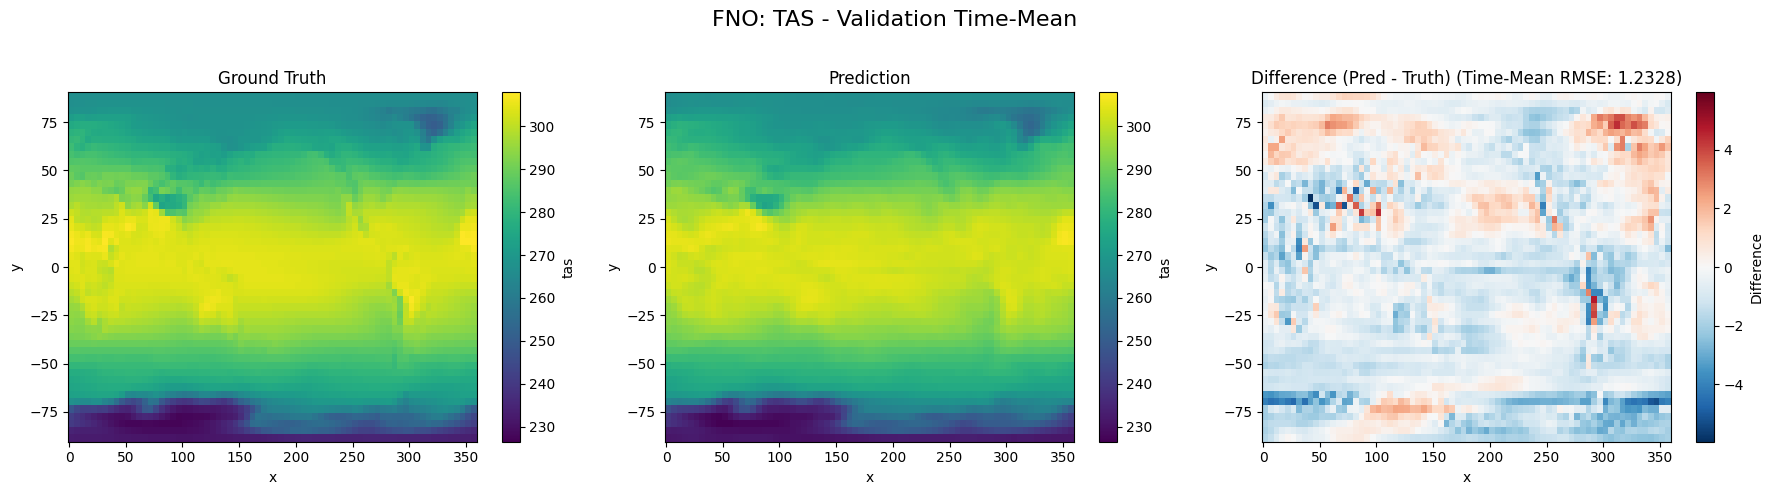

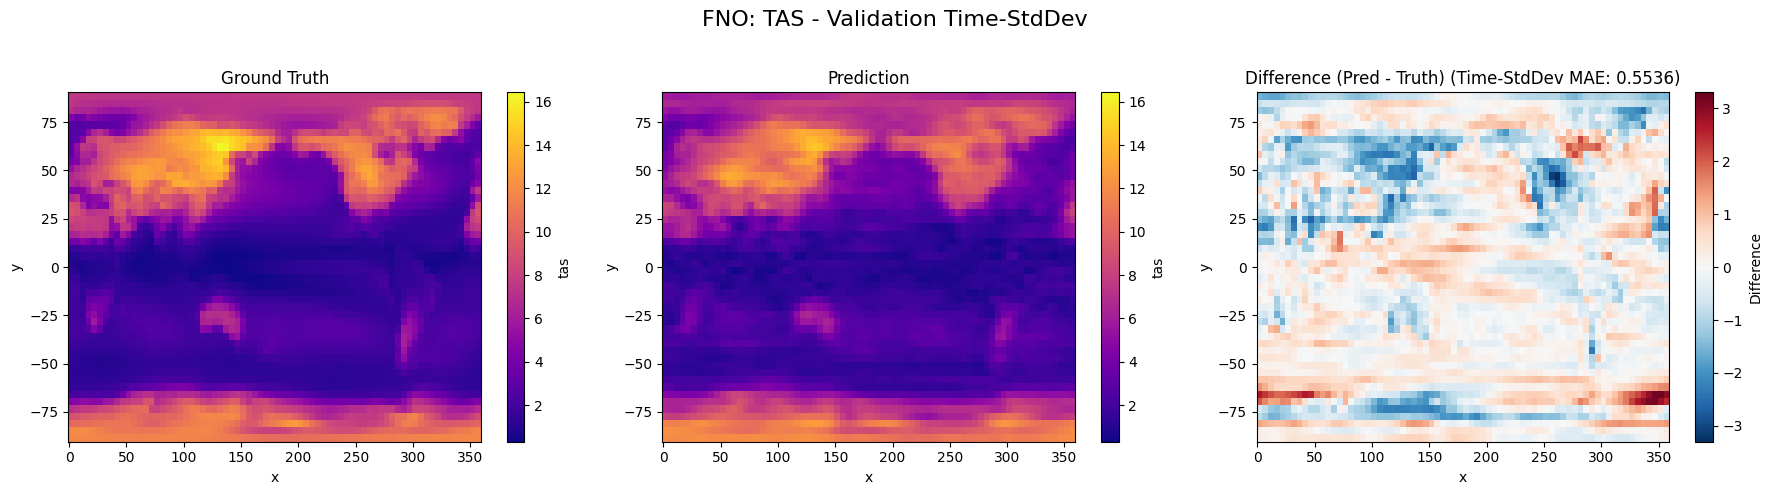

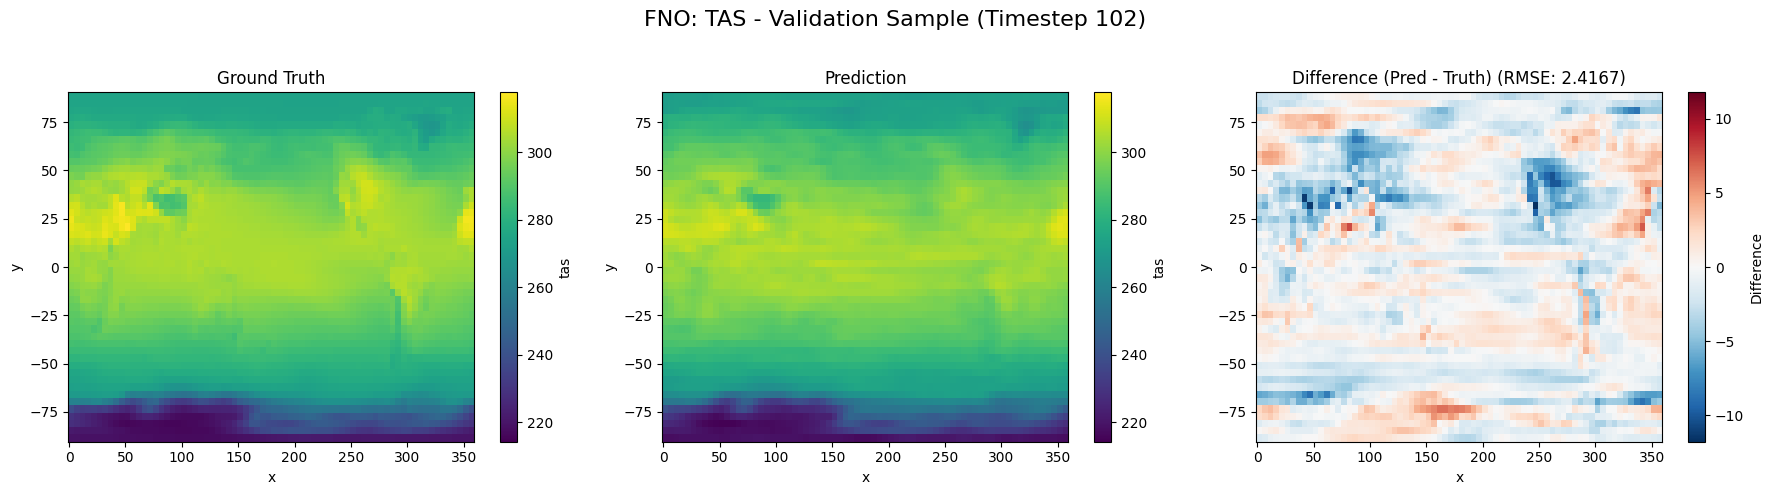

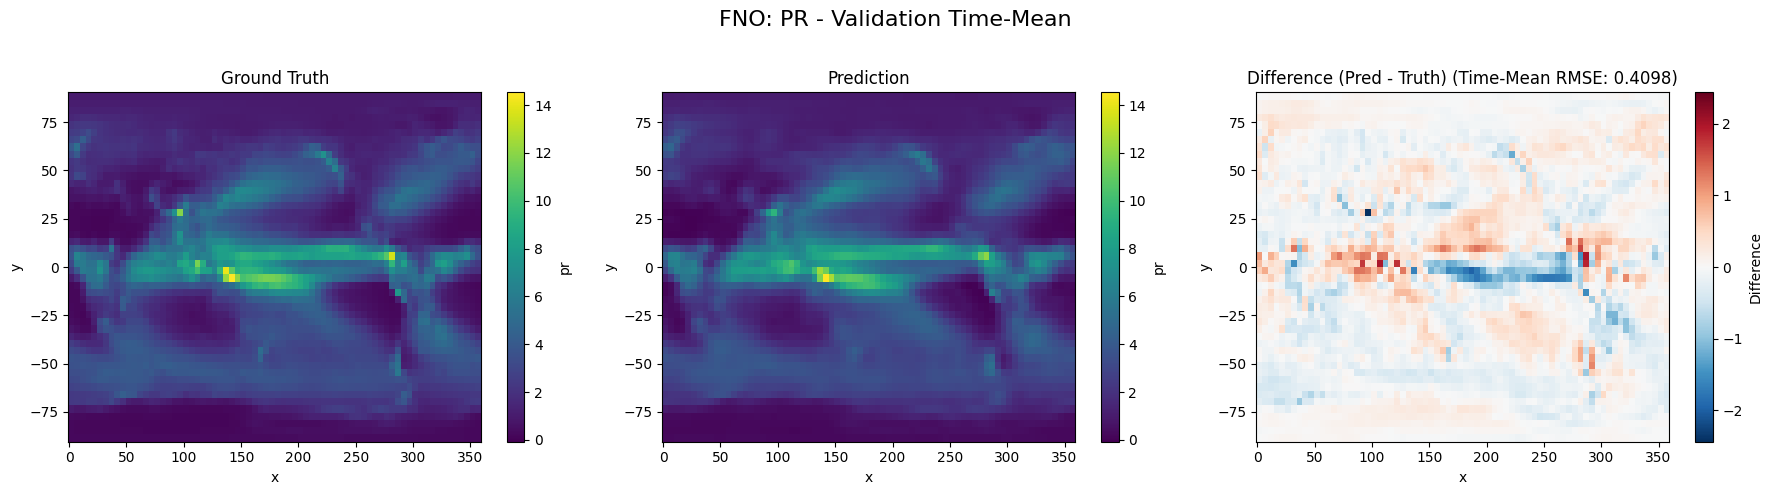

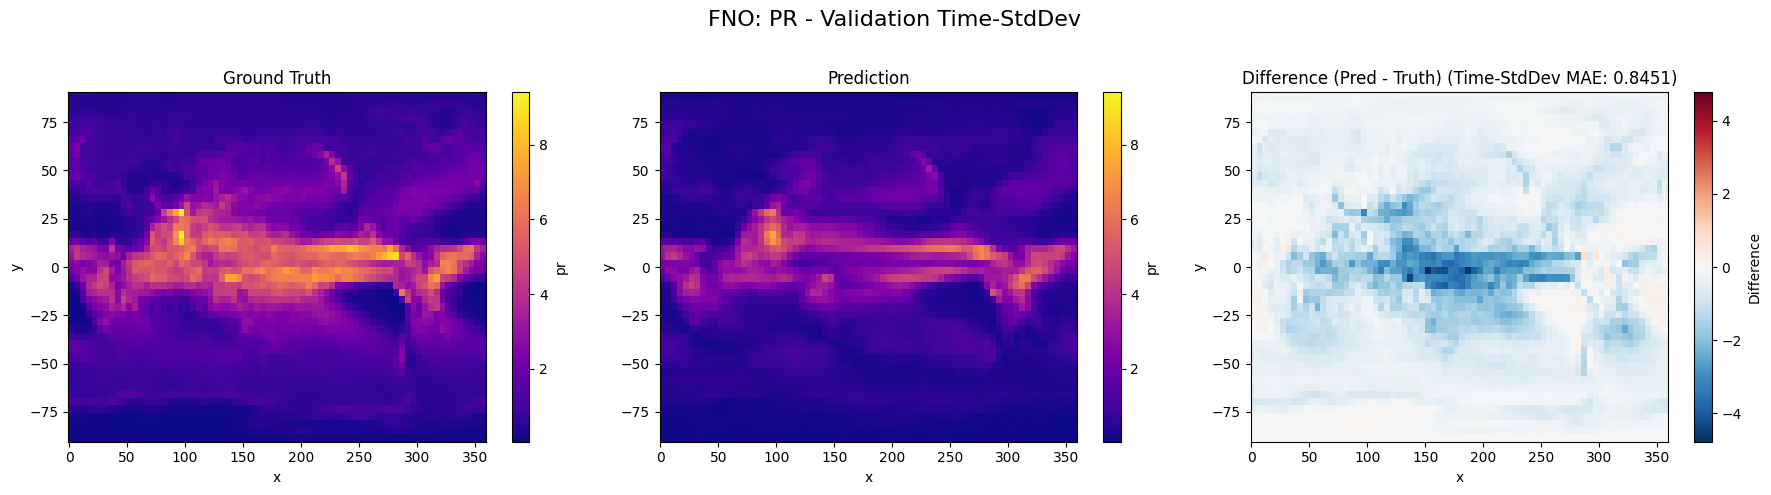

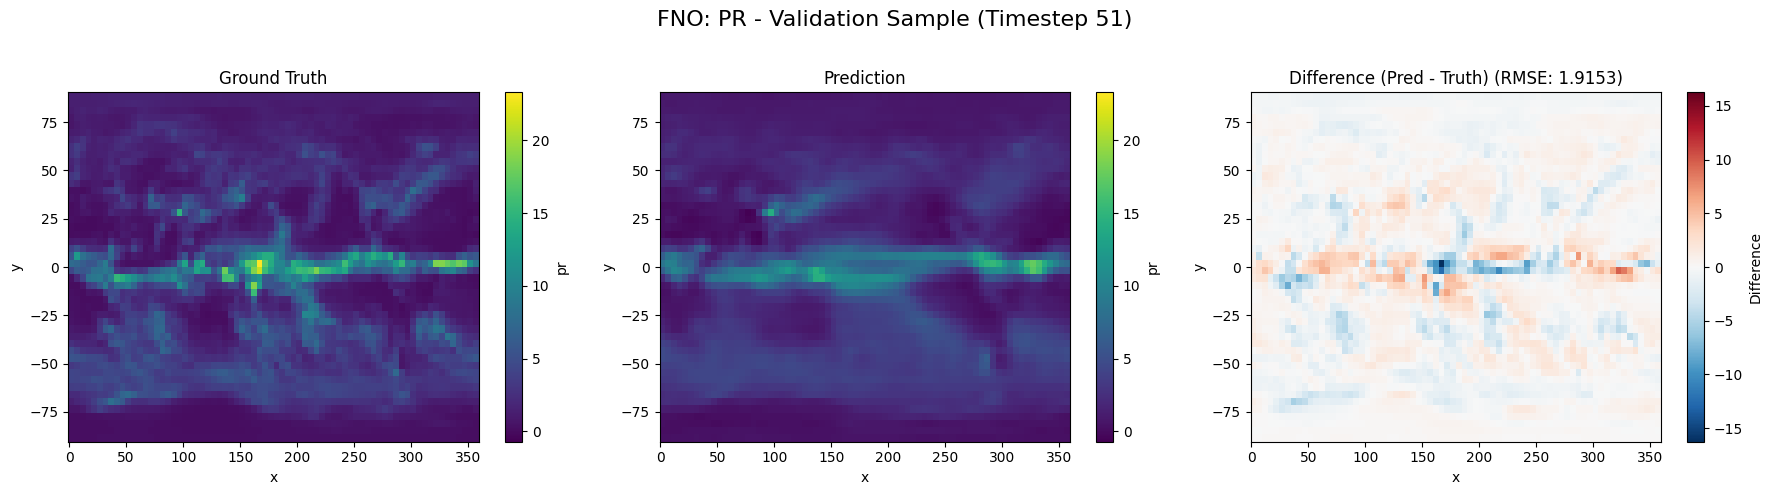

In [10]:
# Cell 10: Visualization Script for FNO (Optional)

try:
    # Ensure these files were saved by the FNO training run
    val_preds_loaded_fno = np.load("val_preds.npy") 
    val_trues_loaded_fno = np.load("val_trues.npy")

    if not hasattr(datamodule, 'lat') or datamodule.lat is None:
        print("Datamodule not fully set up for visualization. Setting it up...")
        datamodule.setup(stage="fit") 

    lat, lon = datamodule.get_coords()
    output_vars = config["data"]["output_vars"] 
    area_weights_vis = datamodule.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded_fno.shape[0])

    print(f"\n--- Visualizing Validation Predictions for FNO ---")
    for i, var_name in enumerate(output_vars):
        pred_xr_fno = xr.DataArray(val_preds_loaded_fno[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr_fno = xr.DataArray(val_trues_loaded_fno[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean_fno = pred_xr_fno.mean("time")
        true_mean_fno = true_xr_fno.mean("time")
        mean_rmse_var_fno = np.sqrt(((pred_mean_fno - true_mean_fno) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean_fno, pred_mean_fno, 
                        f"FNO: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var_fno, metric_name="Time-Mean RMSE")

        pred_std_fno = pred_xr_fno.std("time")
        true_std_fno = true_xr_fno.std("time")
        std_mae_var_fno = np.abs(pred_std_fno - true_std_fno).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std_fno, pred_std_fno, 
                        f"FNO: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var_fno, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random_fno = np.random.randint(0, len(time_val_coords))
            pred_sample_fno = pred_xr_fno.isel(time=t_idx_random_fno)
            true_sample_fno = true_xr_fno.isel(time=t_idx_random_fno)
            sample_rmse_var_fno = np.sqrt(((pred_sample_fno - true_sample_fno) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample_fno, pred_sample_fno, 
                            f"FNO: {var_name.upper()} - Validation Sample (Timestep {t_idx_random_fno})",
                            metric_val=sample_rmse_var_fno, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found for FNO. "
          "Ensure that the FNO training and validation loop (trainer_fno.fit) has been run successfully, "
          "and the on_validation_epoch_end method in ClimateEmulationModule saved these files.")
except AttributeError as e:
    print(f"AttributeError during FNO visualization: {e}. Ensure datamodule is correctly initialized and set up.")
except Exception as e:
    print(f"An error occurred during FNO visualization: {e}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Starting FNO Fine-Tuning ---

--- FNO Fine-Tuning Run 1/4 ---
Parameters: {'fno_modes1': 12, 'fno_modes2': 12, 'fno_width': 20, 'fno_num_layers': 3, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 6}
Fitting FNO model for run 1 with params: {'fno_modes1': 12, 'fno_modes2': 12, 'fno_width': 20, 'fno_num_layers': 3, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 6}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FNO2d   | 349 K  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.400     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.5433, Time-Mean RMSE=5.2918, Time-Stddev MAE=4.1111
[VAL] pr: RMSE=3.3570, Time-Mean RMSE=1.8112, Time-Stddev MAE=1.6103


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1076, Time-Mean RMSE=2.7102, Time-Stddev MAE=1.6589
[VAL] pr: RMSE=3.0230, Time-Mean RMSE=1.2558, Time-Stddev MAE=1.4506


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4209, Time-Mean RMSE=2.4316, Time-Stddev MAE=1.1895
[VAL] pr: RMSE=2.7598, Time-Mean RMSE=0.7615, Time-Stddev MAE=1.3360


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2257, Time-Mean RMSE=2.2995, Time-Stddev MAE=1.1312
[VAL] pr: RMSE=2.7006, Time-Mean RMSE=0.7050, Time-Stddev MAE=1.3654


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1455, Time-Mean RMSE=2.2474, Time-Stddev MAE=1.1755
[VAL] pr: RMSE=2.6858, Time-Mean RMSE=0.7111, Time-Stddev MAE=1.3641


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


[VAL] tas: RMSE=4.0746, Time-Mean RMSE=2.1688, Time-Stddev MAE=1.1208
[VAL] pr: RMSE=2.6817, Time-Mean RMSE=0.7111, Time-Stddev MAE=1.3448
Evaluating FNO model from run 1 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_1/checkpoints/best-fno-epoch=05-val/loss=0.306.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_1/checkpoints/best-fno-epoch=05-val/loss=0.306.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0746, Time-Mean RMSE=2.1688, Time-Stddev MAE=1.1208
[VAL] pr: RMSE=2.6817, Time-Mean RMSE=0.7111, Time-Stddev MAE=1.3448


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.3062913119792938     │
│        val/pr/rmse        │     2.681705951690674     │
│   val/pr/time_mean_rmse   │    0.7110589146614075     │
│    val/pr/time_std_mae    │    1.3448361158370972     │
│       val/tas/rmse        │     4.074644565582275     │
│  val/tas/time_mean_rmse   │    2.1688199043273926     │
│   val/tas/time_std_mae    │    1.1207809448242188     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Run 1 (FNO) Validation Loss: 0.3063

--- FNO Fine-Tuning Run 2/4 ---
Parameters: {'fno_modes1': 16, 'fno_modes2': 16, 'fno_width': 32, 'fno_num_layers': 4, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 6}
Fitting FNO model for run 2 with params: {'fno_modes1': 16, 'fno_modes2': 16, 'fno_width': 32, 'fno_num_layers': 4, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 6}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FNO2d   | 2.1 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.424     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6930, Time-Mean RMSE=3.8302, Time-Stddev MAE=1.6222
[VAL] pr: RMSE=3.1979, Time-Mean RMSE=1.6020, Time-Stddev MAE=1.5941


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0766, Time-Mean RMSE=2.3318, Time-Stddev MAE=1.1263
[VAL] pr: RMSE=2.7005, Time-Mean RMSE=0.7551, Time-Stddev MAE=1.3617


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.8152, Time-Mean RMSE=2.3051, Time-Stddev MAE=1.0870
[VAL] pr: RMSE=2.5070, Time-Mean RMSE=0.6045, Time-Stddev MAE=1.2663


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.4831, Time-Mean RMSE=2.1335, Time-Stddev MAE=0.9764
[VAL] pr: RMSE=2.3337, Time-Mean RMSE=0.5953, Time-Stddev MAE=1.0948


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.2686, Time-Mean RMSE=1.9752, Time-Stddev MAE=0.8981
[VAL] pr: RMSE=2.2769, Time-Mean RMSE=0.6308, Time-Stddev MAE=1.0315


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.1550, Time-Mean RMSE=1.8260, Time-Stddev MAE=0.9028
[VAL] pr: RMSE=2.2510, Time-Mean RMSE=0.5905, Time-Stddev MAE=1.0147


`Trainer.fit` stopped: `max_epochs=6` reached.


Evaluating FNO model from run 2 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_2/checkpoints/best-fno-epoch=05-val/loss=0.214.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_2/checkpoints/best-fno-epoch=05-val/loss=0.214.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.1550, Time-Mean RMSE=1.8260, Time-Stddev MAE=0.9028
[VAL] pr: RMSE=2.2510, Time-Mean RMSE=0.5905, Time-Stddev MAE=1.0147


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.21416451036930084    │
│        val/pr/rmse        │    2.2509946823120117     │
│   val/pr/time_mean_rmse   │    0.5905336737632751     │
│    val/pr/time_std_mae    │     1.014673113822937     │
│       val/tas/rmse        │    3.1550118923187256     │
│  val/tas/time_mean_rmse   │    1.8260012865066528     │
│   val/tas/time_std_mae    │    0.9028078317642212     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Run 2 (FNO) Validation Loss: 0.2142

--- FNO Fine-Tuning Run 3/4 ---
Parameters: {'fno_modes1': 12, 'fno_modes2': 12, 'fno_width': 32, 'fno_num_layers': 4, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 6}
Fitting FNO model for run 3 with params: {'fno_modes1': 12, 'fno_modes2': 12, 'fno_width': 32, 'fno_num_layers': 4, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 6}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FNO2d   | 1.2 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.754     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=12.1611, Time-Mean RMSE=8.3783, Time-Stddev MAE=6.3436
[VAL] pr: RMSE=3.5477, Time-Mean RMSE=2.1086, Time-Stddev MAE=1.7621


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.0230, Time-Mean RMSE=5.0333, Time-Stddev MAE=3.7110
[VAL] pr: RMSE=3.3359, Time-Mean RMSE=1.7735, Time-Stddev MAE=1.6603


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.7912, Time-Mean RMSE=3.8301, Time-Stddev MAE=1.6504
[VAL] pr: RMSE=3.2150, Time-Mean RMSE=1.6300, Time-Stddev MAE=1.6001


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.2054, Time-Mean RMSE=3.2864, Time-Stddev MAE=1.5738
[VAL] pr: RMSE=3.0022, Time-Mean RMSE=1.2850, Time-Stddev MAE=1.4940


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4228, Time-Mean RMSE=2.4786, Time-Stddev MAE=1.3271
[VAL] pr: RMSE=2.8013, Time-Mean RMSE=0.9196, Time-Stddev MAE=1.4132


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


[VAL] tas: RMSE=4.2183, Time-Mean RMSE=2.4363, Time-Stddev MAE=1.2107
[VAL] pr: RMSE=2.6961, Time-Mean RMSE=0.7709, Time-Stddev MAE=1.3354
Evaluating FNO model from run 3 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_3/checkpoints/best-fno-epoch=05-val/loss=0.311.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_3/checkpoints/best-fno-epoch=05-val/loss=0.311.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2183, Time-Mean RMSE=2.4363, Time-Stddev MAE=1.2107
[VAL] pr: RMSE=2.6961, Time-Mean RMSE=0.7709, Time-Stddev MAE=1.3354


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.3113248944282532     │
│        val/pr/rmse        │    2.6961348056793213     │
│   val/pr/time_mean_rmse   │    0.7709206938743591     │
│    val/pr/time_std_mae    │    1.3354039192199707     │
│       val/tas/rmse        │     4.218274116516113     │
│  val/tas/time_mean_rmse   │    2.4363319873809814     │
│   val/tas/time_std_mae    │     1.210730791091919     │
└───────────────────────────┴───────────────────────────┘

Run 3 (FNO) Validation Loss: 0.3113

--- FNO Fine-Tuning Run 4/4 ---
Parameters: {'fno_modes1': 20, 'fno_modes2': 20, 'fno_width': 40, 'fno_num_layers': 4, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting FNO model for run 4 with params: {'fno_modes1': 20, 'fno_modes2': 20, 'fno_width': 40, 'fno_num_layers': 4, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 8}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FNO2d   | 5.1 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.529    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6104, Time-Mean RMSE=3.7053, Time-Stddev MAE=1.4769
[VAL] pr: RMSE=3.2003, Time-Mean RMSE=1.6153, Time-Stddev MAE=1.6453


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1374, Time-Mean RMSE=2.5344, Time-Stddev MAE=1.1525
[VAL] pr: RMSE=2.6676, Time-Mean RMSE=0.7744, Time-Stddev MAE=1.3264


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.3860, Time-Mean RMSE=1.7580, Time-Stddev MAE=1.1394
[VAL] pr: RMSE=2.4278, Time-Mean RMSE=0.6488, Time-Stddev MAE=1.1432


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.9444, Time-Mean RMSE=1.6704, Time-Stddev MAE=0.8557
[VAL] pr: RMSE=2.2350, Time-Mean RMSE=0.5754, Time-Stddev MAE=0.9735


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.5974, Time-Mean RMSE=1.4464, Time-Stddev MAE=0.6725
[VAL] pr: RMSE=2.1507, Time-Mean RMSE=0.4912, Time-Stddev MAE=0.8885


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.4693, Time-Mean RMSE=1.3680, Time-Stddev MAE=0.6394
[VAL] pr: RMSE=2.1281, Time-Mean RMSE=0.4604, Time-Stddev MAE=0.8956


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.4751, Time-Mean RMSE=1.4131, Time-Stddev MAE=0.6597
[VAL] pr: RMSE=2.1214, Time-Mean RMSE=0.4607, Time-Stddev MAE=0.9015


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.4264, Time-Mean RMSE=1.3481, Time-Stddev MAE=0.6386
[VAL] pr: RMSE=2.1187, Time-Mean RMSE=0.4531, Time-Stddev MAE=0.9021


`Trainer.fit` stopped: `max_epochs=8` reached.


Evaluating FNO model from run 4 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_4/checkpoints/best-fno-epoch=07-val/loss=0.186.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_fno_run_4/checkpoints/best-fno-epoch=07-val/loss=0.186.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.4264, Time-Mean RMSE=1.3481, Time-Stddev MAE=0.6386
[VAL] pr: RMSE=2.1187, Time-Mean RMSE=0.4531, Time-Stddev MAE=0.9021


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.18588298559188843    │
│        val/pr/rmse        │     2.118698835372925     │
│   val/pr/time_mean_rmse   │    0.4531424939632416     │
│    val/pr/time_std_mae    │    0.9020577669143677     │
│       val/tas/rmse        │     2.426377058029175     │
│  val/tas/time_mean_rmse   │    1.3480846881866455     │
│   val/tas/time_std_mae    │    0.6385854482650757     │
└───────────────────────────┴───────────────────────────┘

Run 4 (FNO) Validation Loss: 0.1859

--- FNO Fine-Tuning Complete ---
Params: {'fno_modes1': 12, 'fno_modes2': 12, 'fno_width': 20, 'fno_num_layers': 3, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 6}, Best Val Loss: 0.3063
Params: {'fno_modes1': 16, 'fno_modes2': 16, 'fno_width': 32, 'fno_num_layers': 4, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 6}, Best Val Loss: 0.2142
Params: {'fno_modes1': 12, 'fno_modes2': 12, 'fno_width': 32, 'fno_num_layers': 4, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 6}, Best Val Loss: 0.3113
Params: {'fno_modes1': 20, 'fno_modes2': 20, 'fno_width': 40, 'fno_num_layers': 4, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 8}, Best Val Loss: 0.1859

Best performing FNO parameter set:
Params: {'fno_mo

In [12]:
# Cell 12: FNO - Final Training & Testing with Best Hyperparameters

print("\n--- Starting FNO Final Training with Best Hyperparameters ---")

# Ensure 'best_run_fno' exists from the FNO fine-tuning loop
if 'best_run_fno' not in globals() or best_run_fno is None:
    print("Error: 'best_run_fno' not found. Please run the FNO fine-tuning loop first.")
else:
    print(f"Using best FNO parameters: {best_run_fno['params']}")

    # 1. Create a deep copy of the base config and update with best params
    final_config_fno = deepcopy(config)
    best_params_fno = best_run_fno['params']

    final_config_fno["data"]["batch_size"] = best_params_fno["batch_size"]
    final_config_fno["model_fno"]["modes1"] = best_params_fno["fno_modes1"]
    final_config_fno["model_fno"]["modes2"] = best_params_fno["fno_modes2"]
    final_config_fno["model_fno"]["width"] = best_params_fno["fno_width"]
    final_config_fno["model_fno"]["num_fourier_layers"] = best_params_fno["fno_num_layers"]
    
    final_max_epochs_fno = config["trainer"].get("max_epochs", 20) 

    # 2. Re-instantiate DataModule
    datamodule_final_fno = ClimateDataModule(**final_config_fno["data"])

    # 3. Re-instantiate FNO model
    n_inputs_final_fno = len(final_config_fno["data"]["input_vars"])
    n_outputs_final_fno = len(final_config_fno["data"]["output_vars"])
    
    fno_model_final = FNO2d(
        n_input_channels=n_inputs_final_fno, 
        n_output_channels=n_outputs_final_fno, 
        modes1=final_config_fno["model_fno"]["modes1"],
        modes2=final_config_fno["model_fno"]["modes2"],
        width=final_config_fno["model_fno"]["width"],
        num_fourier_layers=final_config_fno["model_fno"]["num_fourier_layers"]
    )

    # 4. Re-instantiate LightningModule
    lightning_module_final_fno = ClimateEmulationModule(
        fno_model_final, 
        learning_rate=best_params_fno["lr"]
    )

    # Override configure_optimizers
    def final_configure_optimizers_fno(self_lm):
        if best_params_fno["optimizer_type"] == "AdamW":
            optimizer = optim.AdamW(self_lm.parameters(), lr=self_lm.hparams.learning_rate, weight_decay=0.01)
        else: 
            optimizer = optim.Adam(self_lm.parameters(), lr=self_lm.hparams.learning_rate)
        
        if best_params_fno["scheduler_type"] == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=final_max_epochs_fno, eta_min=1e-6)
            return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}
        return optimizer

    import types
    lightning_module_final_fno.configure_optimizers = types.MethodType(final_configure_optimizers_fno, lightning_module_final_fno)

    # 5. Re-instantiate Trainer
    final_run_dir_fno = "final_fno_run"
    
    final_checkpoint_callback_fno = ModelCheckpoint(
        monitor="val/loss",
        mode="min",
        dirpath=os.path.join("lightning_logs", final_run_dir_fno, "checkpoints"),
        filename="final-best-fno-{epoch:02d}-{val/loss:.3f}",
        save_top_k=1,
        verbose=True
    )
    final_early_stop_callback_fno = EarlyStopping(monitor="val/loss", patience=10, verbose=True, mode="min")
    final_progress_bar_fno = TQDMProgressBar(refresh_rate=10)
    
    base_config_trainer_fixed_final_fno = {k: v for k, v in config["trainer"].items() if k not in ["max_epochs", "callbacks", "logger", "default_root_dir"]}
    trainer_final_config_fno = {
        **base_config_trainer_fixed_final_fno,
        "max_epochs": final_max_epochs_fno,
        "callbacks": [final_checkpoint_callback_fno, final_early_stop_callback_fno, final_progress_bar_fno],
        "logger": pl.loggers.TensorBoardLogger("tb_logs", name=final_run_dir_fno),
        "default_root_dir": os.path.join("lightning_logs", final_run_dir_fno)
    }
    trainer_final_fno = pl.Trainer(**trainer_final_config_fno)

    # 6. Run final training
    print(f"Fitting final FNO model with best params: {best_params_fno}")
    trainer_final_fno.fit(lightning_module_final_fno, datamodule=datamodule_final_fno)
    
    # 7. Test on the actual test set (ssp245)
    print(f"Testing final FNO model on test set (ssp245)...")
    final_test_results_fno = trainer_final_fno.test(lightning_module_final_fno, datamodule=datamodule_final_fno, ckpt_path="best")
    print("Final FNO Test Results (on ssp245):", final_test_results_fno)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Starting FNO Final Training with Best Hyperparameters ---
Using best FNO parameters: {'fno_modes1': 20, 'fno_modes2': 20, 'fno_width': 40, 'fno_num_layers': 4, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 8}
Fitting final FNO model with best params: {'fno_modes1': 20, 'fno_modes2': 20, 'fno_width': 40, 'fno_num_layers': 4, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 8}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FNO2d   | 5.1 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.529    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.459
Epoch 0, global step 92: 'val/loss' reached 0.45909 (best 0.45909), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=00-val/loss=0.459.ckpt' as top 1


[VAL] tas: RMSE=5.5857, Time-Mean RMSE=3.6798, Time-Stddev MAE=1.5284
[VAL] pr: RMSE=3.2005, Time-Mean RMSE=1.6144, Time-Stddev MAE=1.6304


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.152 >= min_delta = 0.0. New best score: 0.308
Epoch 1, global step 184: 'val/loss' reached 0.30752 (best 0.30752), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=01-val/loss=0.308.ckpt' as top 1


[VAL] tas: RMSE=4.0478, Time-Mean RMSE=2.2772, Time-Stddev MAE=1.0964
[VAL] pr: RMSE=2.6883, Time-Mean RMSE=0.7718, Time-Stddev MAE=1.3094


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.053 >= min_delta = 0.0. New best score: 0.255
Epoch 2, global step 276: 'val/loss' reached 0.25482 (best 0.25482), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=02-val/loss=0.255.ckpt' as top 1


[VAL] tas: RMSE=3.7309, Time-Mean RMSE=2.3107, Time-Stddev MAE=1.0033
[VAL] pr: RMSE=2.4572, Time-Mean RMSE=0.6209, Time-Stddev MAE=1.1654


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.044 >= min_delta = 0.0. New best score: 0.211
Epoch 3, global step 368: 'val/loss' reached 0.21097 (best 0.21097), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=03-val/loss=0.211.ckpt' as top 1


[VAL] tas: RMSE=3.1369, Time-Mean RMSE=1.7627, Time-Stddev MAE=1.0331
[VAL] pr: RMSE=2.2365, Time-Mean RMSE=0.5732, Time-Stddev MAE=0.9748


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.020 >= min_delta = 0.0. New best score: 0.191
Epoch 4, global step 460: 'val/loss' reached 0.19113 (best 0.19113), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=04-val/loss=0.191.ckpt' as top 1


[VAL] tas: RMSE=2.6648, Time-Mean RMSE=1.4617, Time-Stddev MAE=0.7325
[VAL] pr: RMSE=2.1411, Time-Mean RMSE=0.4743, Time-Stddev MAE=0.9202


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.185
Epoch 5, global step 552: 'val/loss' reached 0.18498 (best 0.18498), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=05-val/loss=0.185.ckpt' as top 1


[VAL] tas: RMSE=2.4125, Time-Mean RMSE=1.2607, Time-Stddev MAE=0.6494
[VAL] pr: RMSE=2.1158, Time-Mean RMSE=0.4618, Time-Stddev MAE=0.8681


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.182
Epoch 6, global step 644: 'val/loss' reached 0.18205 (best 0.18205), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=06-val/loss=0.182.ckpt' as top 1


[VAL] tas: RMSE=2.2936, Time-Mean RMSE=1.1579, Time-Stddev MAE=0.6160
[VAL] pr: RMSE=2.1017, Time-Mean RMSE=0.4453, Time-Stddev MAE=0.8717


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.179
Epoch 7, global step 736: 'val/loss' reached 0.17933 (best 0.17933), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=07-val/loss=0.179.ckpt' as top 1


[VAL] tas: RMSE=2.2249, Time-Mean RMSE=1.1222, Time-Stddev MAE=0.5785
[VAL] pr: RMSE=2.0880, Time-Mean RMSE=0.4008, Time-Stddev MAE=0.8898


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.179
Epoch 8, global step 828: 'val/loss' reached 0.17870 (best 0.17870), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=08-val/loss=0.179.ckpt' as top 1


[VAL] tas: RMSE=2.2062, Time-Mean RMSE=1.0980, Time-Stddev MAE=0.5773
[VAL] pr: RMSE=2.0842, Time-Mean RMSE=0.3966, Time-Stddev MAE=0.8765


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.178
Epoch 9, global step 920: 'val/loss' reached 0.17849 (best 0.17849), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=09-val/loss=0.178.ckpt' as top 1


[VAL] tas: RMSE=2.2100, Time-Mean RMSE=1.1241, Time-Stddev MAE=0.5746
[VAL] pr: RMSE=2.0831, Time-Mean RMSE=0.3904, Time-Stddev MAE=0.8798


`Trainer.fit` stopped: `max_epochs=10` reached.


Testing final FNO model on test set (ssp245)...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=09-val/loss=0.178.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_fno_run/checkpoints/final-best-fno-epoch=09-val/loss=0.178.ckpt


Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.6494, Time-Mean RMSE=290.6087, Time-Stddev MAE=3.5235
[TEST] pr: RMSE=4.4715, Time-Mean RMSE=3.9381, Time-Stddev MAE=1.5086
✅ Submission saved to: submissions/kaggle_submission_fno_20250517_050135.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.471450328826904     │
│  test/pr/time_mean_rmse   │     3.938084602355957     │
│   test/pr/time_std_mae    │    1.5086039304733276     │
│       test/tas/rmse       │     290.6493835449219     │
│  test/tas/time_mean_rmse  │     290.608642578125      │
│   test/tas/time_std_mae   │    3.5235257148742676     │
└───────────────────────────┴───────────────────────────┘

Final FNO Test Results (on ssp245): [{'test/tas/rmse': 290.6493835449219, 'test/tas/time_mean_rmse': 290.608642578125, 'test/tas/time_std_mae': 3.5235257148742676, 'test/pr/rmse': 4.471450328826904, 'test/pr/time_mean_rmse': 3.938084602355957, 'test/pr/time_std_mae': 1.5086039304733276}]



--- Visualizing Validation Predictions for Final FNO ---


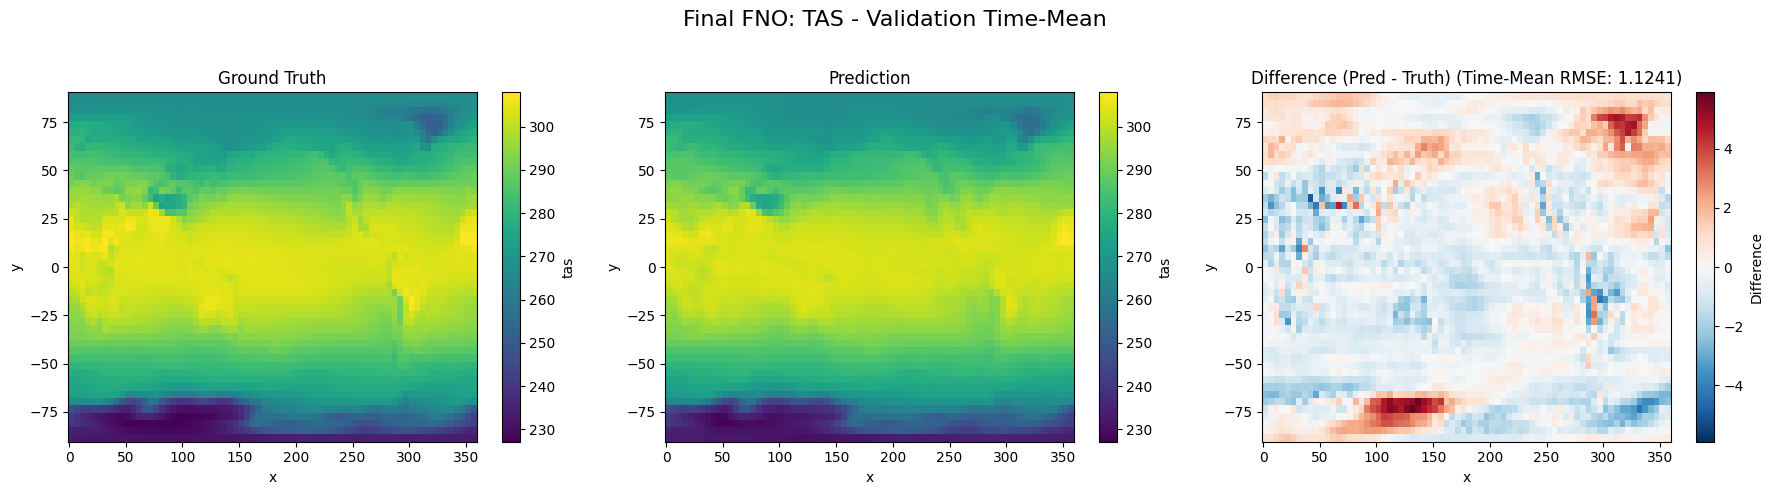

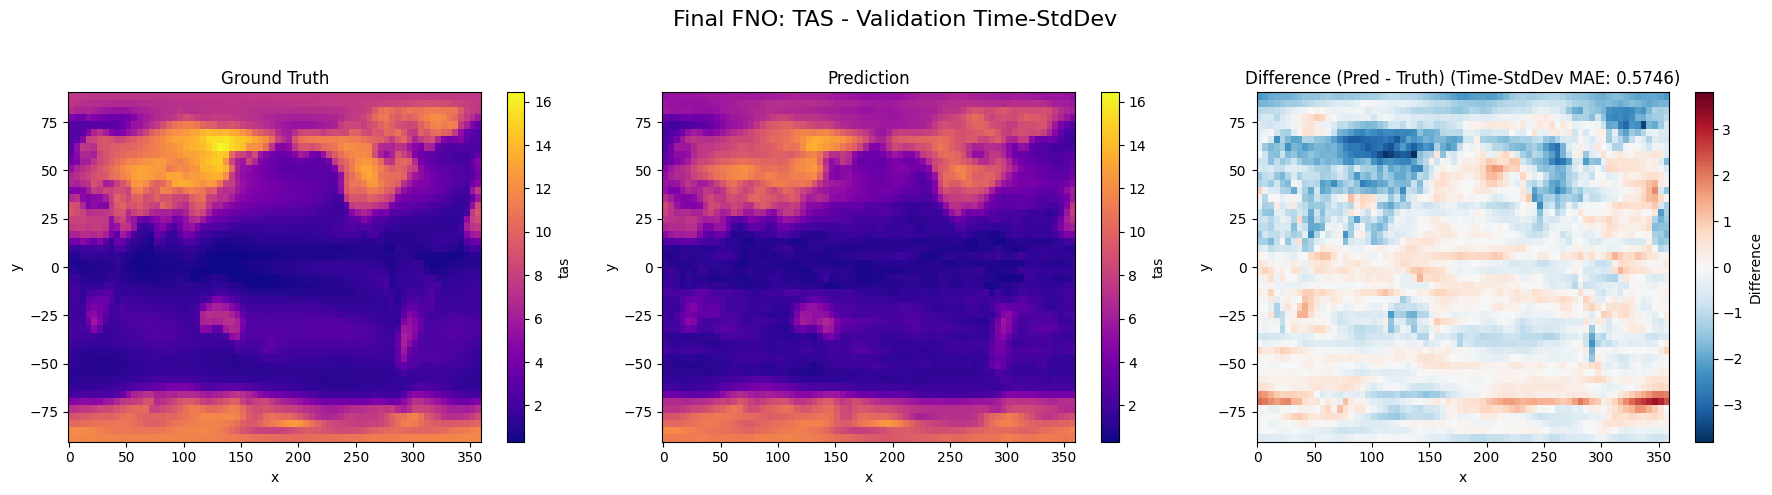

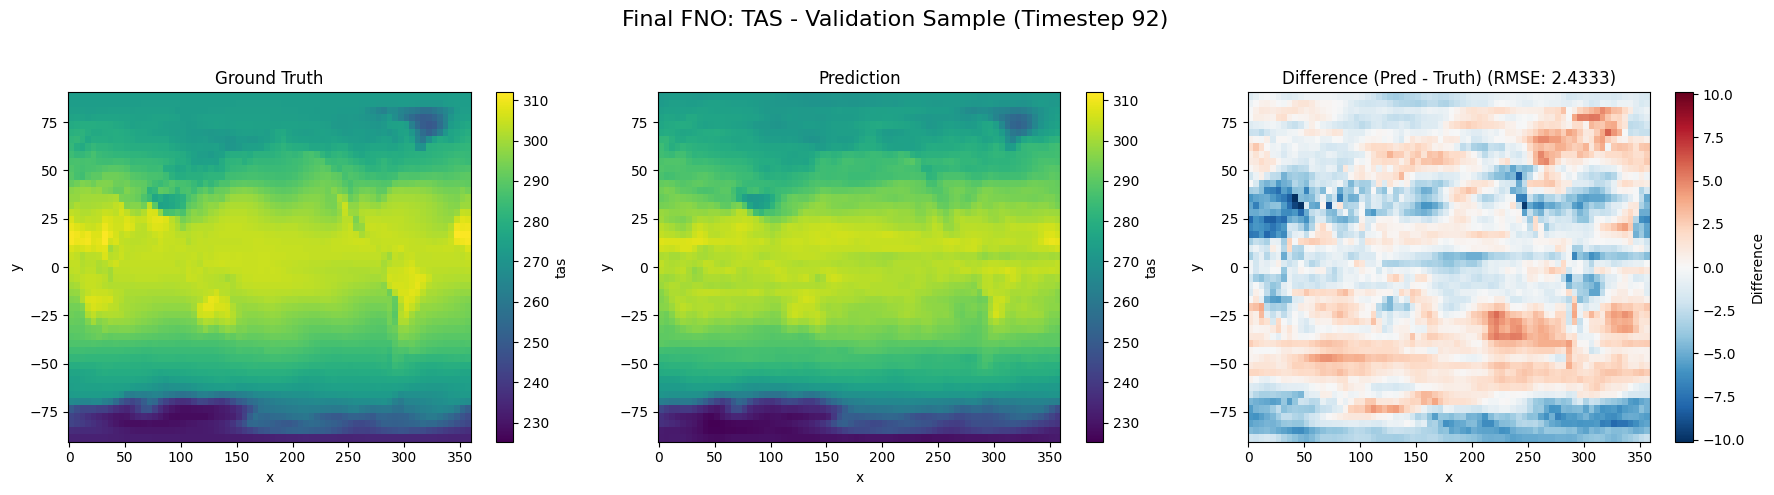

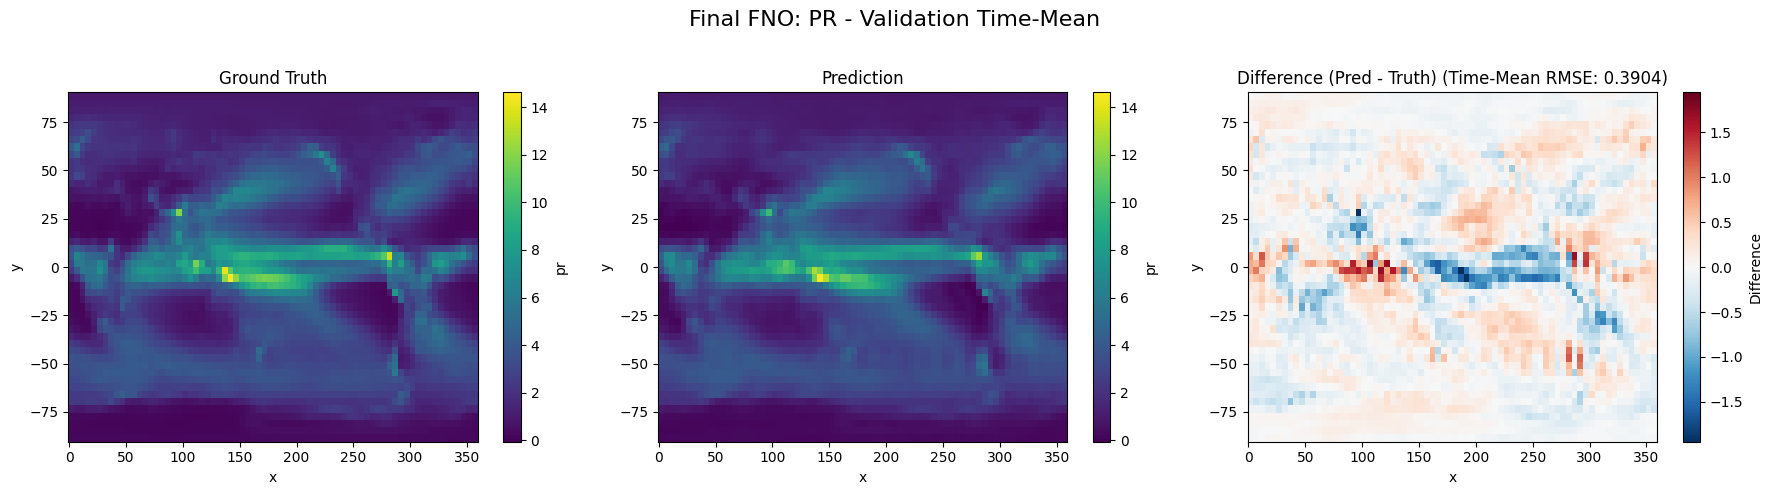

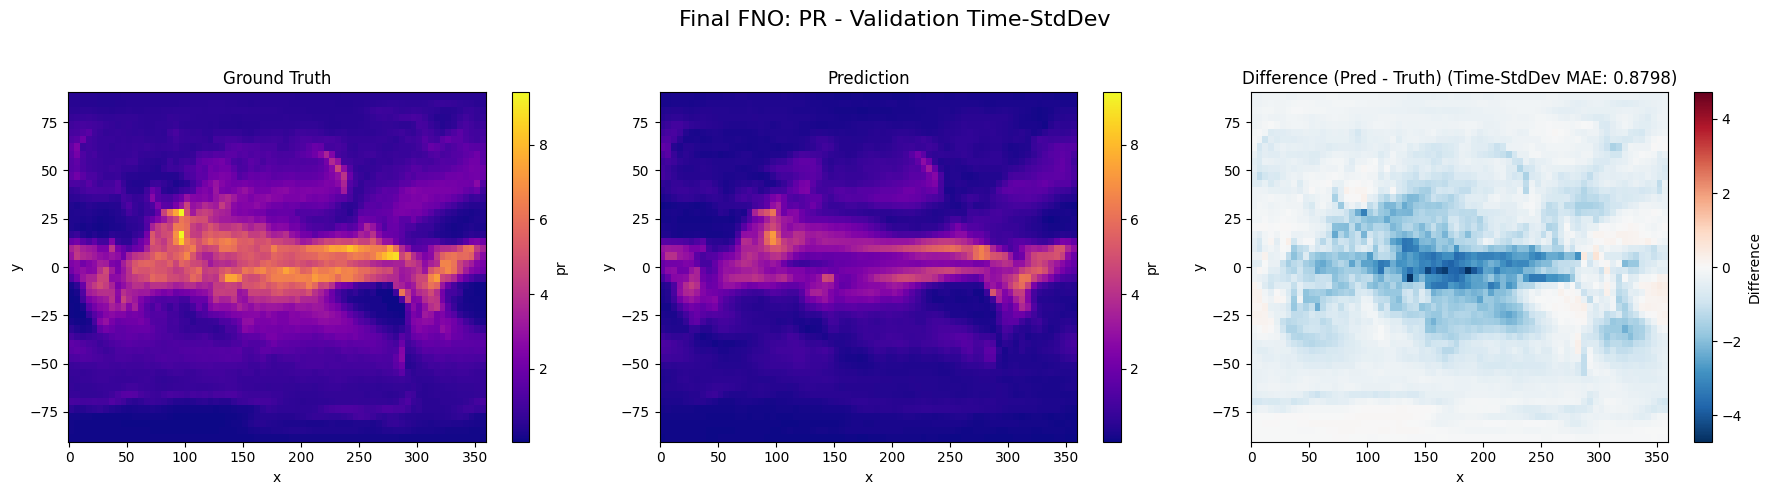

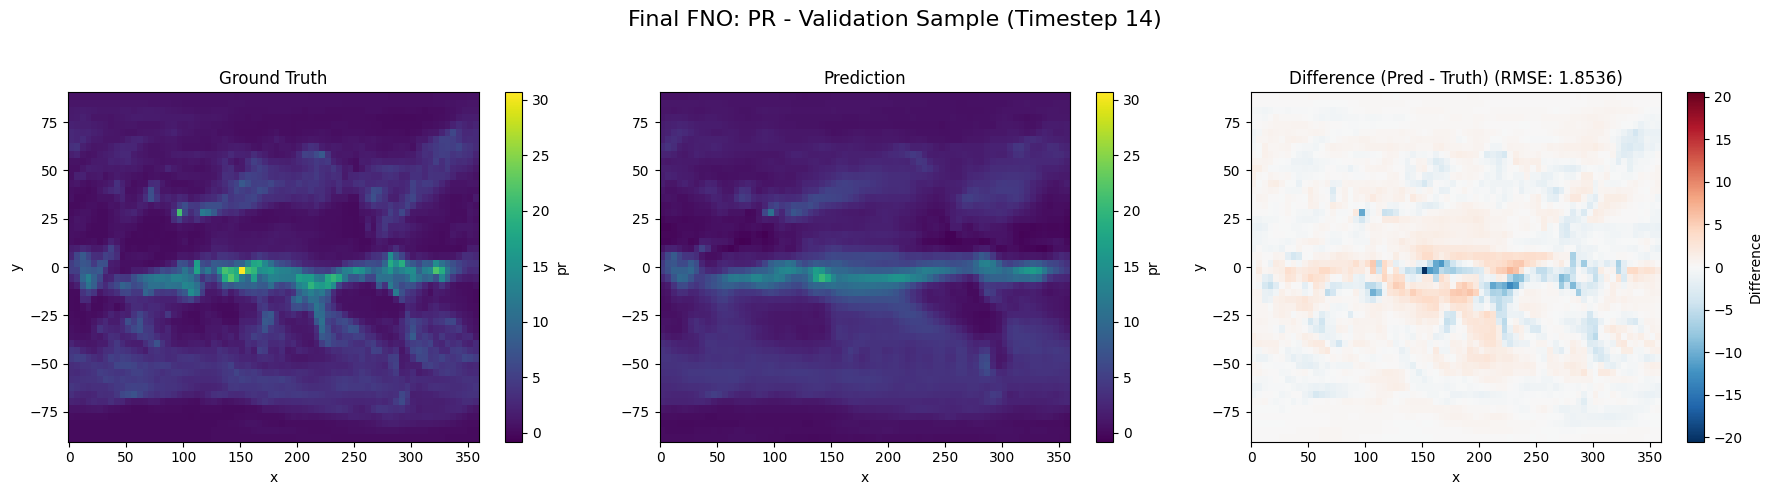

In [13]:
# Cell 13: FNO - Final Visualization
# This cell loads the validation predictions saved during the FINAL FNO training run and plots them.

print(f"\n--- Visualizing Validation Predictions for Final FNO ---")
try:
    val_preds_loaded_final_fno = np.load("val_preds.npy") 
    val_trues_loaded_final_fno = np.load("val_trues.npy")

    if 'datamodule_final_fno' not in globals() or not hasattr(datamodule_final_fno, 'lat') or datamodule_final_fno.lat is None:
        print("datamodule_final_fno not fully set up for visualization. Setting it up...")
        datamodule_final_fno_viz = ClimateDataModule(**config["data"])
        datamodule_final_fno_viz.setup(stage="fit") 
        lat, lon = datamodule_final_fno_viz.get_coords()
        output_vars = config["data"]["output_vars"] 
        area_weights_vis = datamodule_final_fno_viz.get_lat_weights()
    else:
        lat, lon = datamodule_final_fno.get_coords()
        output_vars = config["data"]["output_vars"] 
        area_weights_vis = datamodule_final_fno.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded_final_fno.shape[0])

    for i, var_name in enumerate(output_vars):
        pred_xr_final_fno = xr.DataArray(val_preds_loaded_final_fno[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr_final_fno = xr.DataArray(val_trues_loaded_final_fno[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean_final_fno = pred_xr_final_fno.mean("time")
        true_mean_final_fno = true_xr_final_fno.mean("time")
        mean_rmse_var_final_fno = np.sqrt(((pred_mean_final_fno - true_mean_final_fno) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean_final_fno, pred_mean_final_fno, 
                        f"Final FNO: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var_final_fno, metric_name="Time-Mean RMSE")

        pred_std_final_fno = pred_xr_final_fno.std("time")
        true_std_final_fno = true_xr_final_fno.std("time")
        std_mae_var_final_fno = np.abs(pred_std_final_fno - true_std_final_fno).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std_final_fno, pred_std_final_fno, 
                        f"Final FNO: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var_final_fno, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random_final_fno = np.random.randint(0, len(time_val_coords))
            pred_sample_final_fno = pred_xr_final_fno.isel(time=t_idx_random_final_fno)
            true_sample_final_fno = true_xr_final_fno.isel(time=t_idx_random_final_fno)
            sample_rmse_var_final_fno = np.sqrt(((pred_sample_final_fno - true_sample_final_fno) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample_final_fno, pred_sample_final_fno, 
                            f"Final FNO: {var_name.upper()} - Validation Sample (Timestep {t_idx_random_final_fno})",
                            metric_val=sample_rmse_var_final_fno, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except NameError as e:
    print(f"NameError during FNO final visualization: {e}. Ensure 'best_run' was defined and the final training cell (Cell 21) ran successfully.")
except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found for final FNO run. "
          "Ensure that the final FNO training and validation (Cell 21) has run successfully.")
except AttributeError as e:
    print(f"AttributeError during final FNO visualization: {e}. Ensure datamodule_final_fno is correctly initialized.")
except Exception as e:
    print(f"An error occurred during final FNO visualization: {e}")

